In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 50)

In [8]:
# carregar dados
csv_path = Path('data/btc_limpo.csv')  # <-- ajuste para o seu arquivo
assert csv_path.exists(), f'Arquivo não encontrado: {csv_path}'

df = pd.read_csv(csv_path)

# se 'Date' for coluna, usar como índice; se já for índice, converter
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')
    df = df.set_index('Date')
else:
    df.index = pd.to_datetime(df.index, utc=True, errors='coerce')

# ordenar por data e manter apenas colunas essenciais
df = df.sort_index()
cols = [c for c in ['Open','High','Low','Close','Volume'] if c in df.columns]
df = df[cols].copy()

# garantir tipos numéricos
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# regularizar frequência diária e preencher pequenos buracos
df = df.asfreq('D')
df = df.ffill()

# checar primeiras linhas
df.head()


,Open,Low,Close,Volume
Date,,,,
2020-06-01 00:00:00+00:00,9463.605469,9450.899414,10167.268555,35198901068
2020-06-02 00:00:00+00:00,10162.973633,9460.571289,9529.803711,39137252109
2020-06-03 00:00:00+00:00,9533.760742,9471.846680,9656.717773,25007459262
2020-06-04 00:00:00+00:00,9655.854492,9525.247070,9800.636719,25921805072
2020-06-05 00:00:00+00:00,9800.215820,9663.216797,9665.533203,23509628646


In [9]:
# estatísticas do preço
desc_price = df['Close'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])
print('--- Estatísticas do Preço (Close) ---')
print(desc_price)

# criar retorno percentual e log-retorno
df['return'] = df['Close'].pct_change()
df['log_return'] = np.log(df['Close']).diff()

# estatísticas do retorno
desc_ret = df['return'].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])
print('\n--- Estatísticas do Retorno Diário (pct_change) ---')
print(desc_ret)


--- Estatísticas do Preço (Close) ---
count      1826.000000
mean      43432.230367
std       24748.213095
min        9045.390625
1%         9245.780029
10%       16607.585938
25%       23673.097656
50%       38697.365234
75%       59769.224609
90%       83676.984375
99%      104681.769531
max      111673.281250
Name: Close, dtype: float64

--- Estatísticas do Retorno Diário (pct_change) ---
count    1825.000000
mean        0.001769
std         0.031359
min        -0.159747
1%         -0.085077
10%        -0.031708
25%        -0.012837
50%         0.000627
75%         0.015603
90%         0.036845
99%         0.098484
max         0.187465
Name: return, dtype: float64


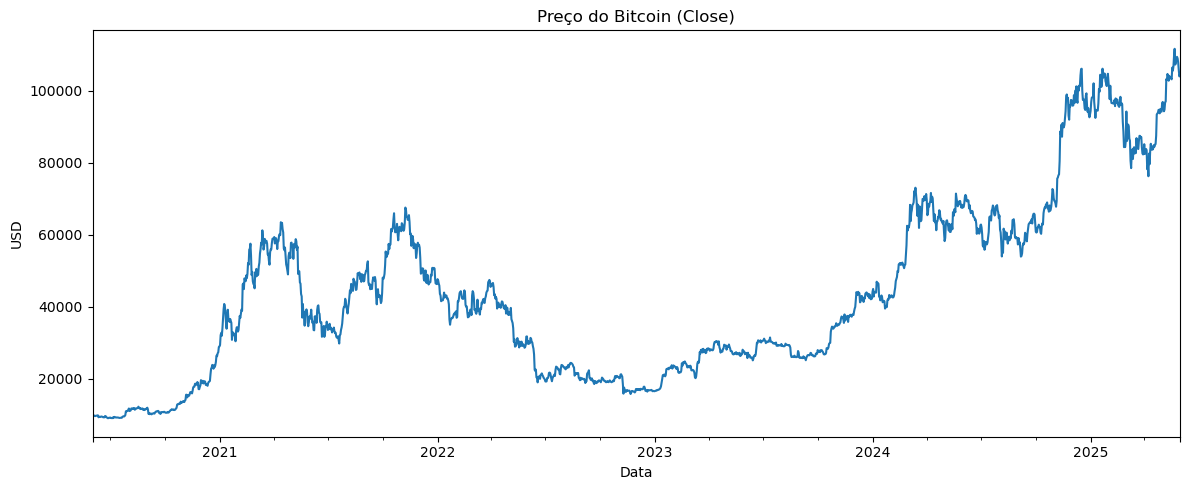

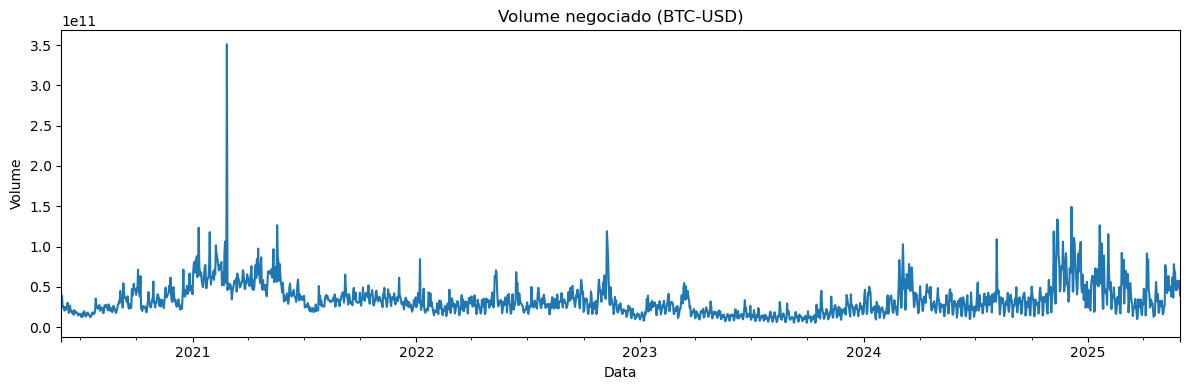

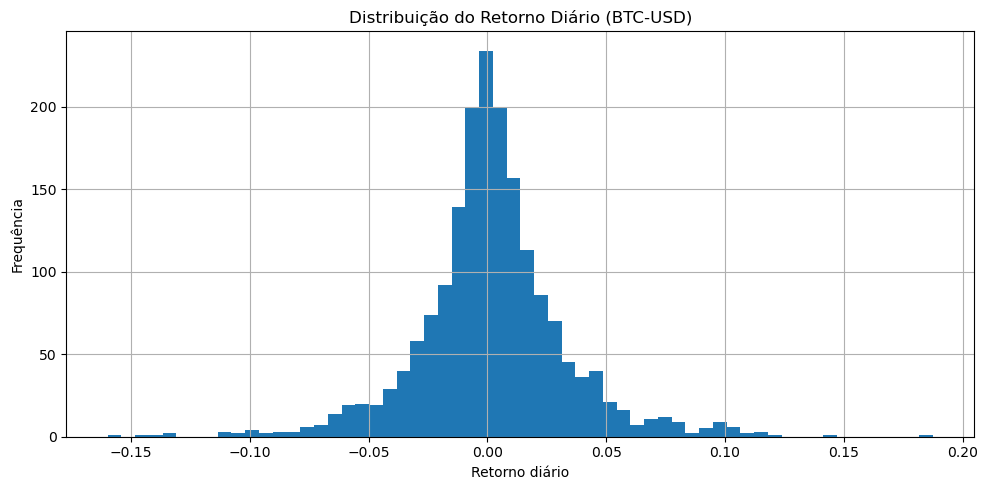

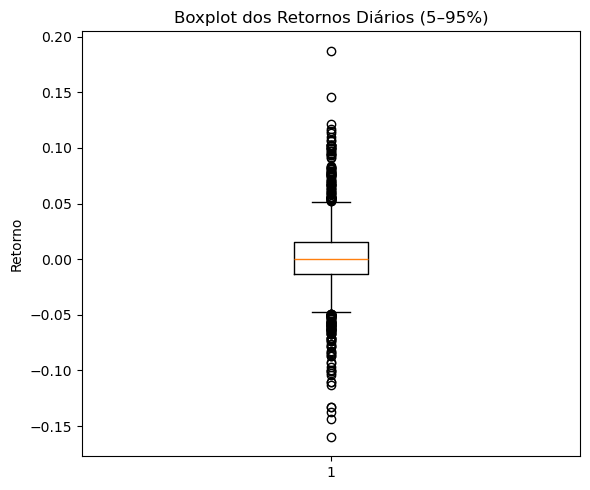

In [11]:
# preço
plt.figure(figsize=(12,5))
df['Close'].plot()
plt.title('Preço do Bitcoin (Close)')
plt.xlabel('Data'); plt.ylabel('USD')
plt.tight_layout()
plt.show()

# volume
if 'Volume' in df.columns:
    plt.figure(figsize=(12,4))
    df['Volume'].plot()
    plt.title('Volume negociado (BTC-USD)')
    plt.xlabel('Data'); plt.ylabel('Volume')
    plt.tight_layout()
    plt.show()

# histograma do retorno
plt.figure(figsize=(10,5))
df['return'].dropna().hist(bins=60)
plt.title('Distribuição do Retorno Diário (BTC-USD)')
plt.xlabel('Retorno diário'); plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# boxplot do retorno
plt.figure(figsize=(6,5))
plt.boxplot(df['return'].dropna(), vert=True, whis=[5,95])
plt.title('Boxplot dos Retornos Diários (5–95%)')
plt.ylabel('Retorno')
plt.tight_layout()
plt.show()


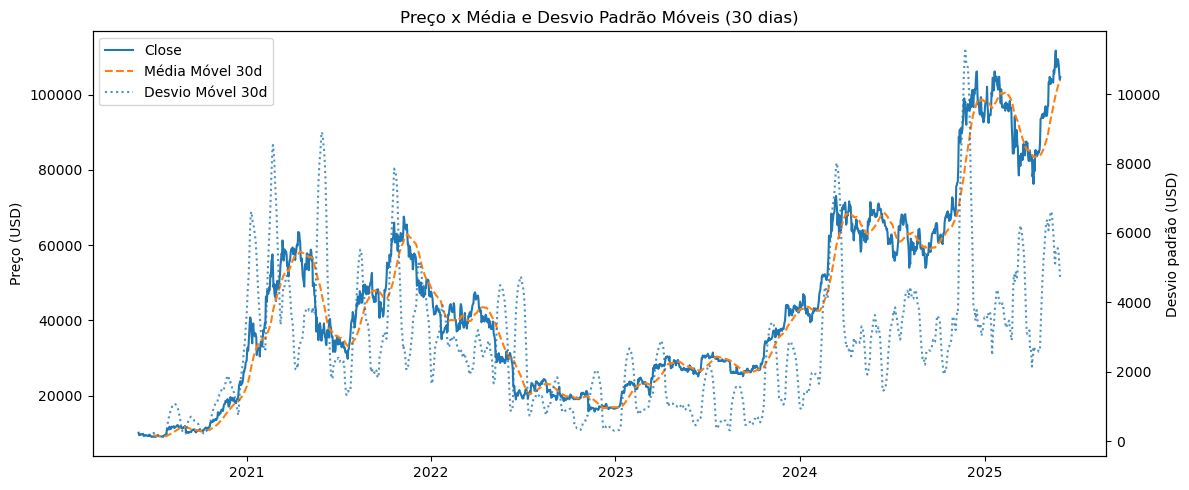

In [12]:
# média/desvio móvel
win = 30
roll_mean = df['Close'].rolling(win).mean()
roll_std  = df['Close'].rolling(win).std()

# gráfico com 2 eixos para escalas diferentes
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df.index, df['Close'], label='Close')
ax1.plot(df.index, roll_mean, label=f'Média Móvel {win}d', linestyle='--')
ax1.set_ylabel('Preço (USD)')
ax1.set_title('Preço x Média e Desvio Padrão Móveis (30 dias)')

ax2 = ax1.twinx()
ax2.plot(df.index, roll_std, label=f'Desvio Móvel {win}d', linestyle=':', alpha=0.8)
ax2.set_ylabel('Desvio padrão (USD)')

# legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(serie, nome='serie'):
    serie = serie.dropna()
    res = adfuller(serie, autolag='AIC')
    out = pd.Series(res[0:4], index=['estatística ADF','p-value','lags usados','n obs'])
    for k, v in res[4].items():
        out[f'valor crítico ({k})'] = v
    print(f'\n=== Teste ADF: {nome} ===')
    print(out)

# ADF no preço em nível
adf_test(df['Close'], 'Close (nível)')

# ADF na 1ª diferença do preço
df['close_diff1'] = df['Close'].diff()
adf_test(df['close_diff1'], 'Close diferenciado (1ª diferença)')

# ADF no retorno percentual
adf_test(df['return'], 'Retorno (pct_change)')



=== Teste ADF: Close (nível) ===
estatística ADF          -0.623338
p-value                   0.865621
lags usados              13.000000
n obs                  1812.000000
valor crítico (1%)       -3.433964
valor crítico (5%)       -2.863136
valor crítico (10%)      -2.567620
dtype: float64

=== Teste ADF: Close diferenciado (1ª diferença) ===
estatística ADF       -1.072969e+01
p-value                3.001859e-19
lags usados            1.200000e+01
n obs                  1.812000e+03
valor crítico (1%)    -3.433964e+00
valor crítico (5%)    -2.863136e+00
valor crítico (10%)   -2.567620e+00
dtype: float64

=== Teste ADF: Retorno (pct_change) ===
estatística ADF         -44.320550
p-value                   0.000000
lags usados               0.000000
n obs                  1824.000000
valor crítico (1%)       -3.433940
valor crítico (5%)       -2.863126
valor crítico (10%)      -2.567614
dtype: float64


In [15]:
# salvar outputs do dia
out_dir = Path('outputs/2025-09-02')
out_dir.mkdir(parents=True, exist_ok=True)

# salvar dataset com colunas novas (return, log_return, close_diff1)
df.to_csv(out_dir / 'btc_enriched_2025-09-02.csv')

# gerar um pequeno resumo textual
summary_lines = []

summary_lines.append('=== Resumo 02/09 ===')
summary_lines.append(f'Período do dataset: {df.index.min().date()} a {df.index.max().date()}')
summary_lines.append('')
summary_lines.append('--- Estatísticas do Preço (Close) ---')
summary_lines.append(str(desc_price))
summary_lines.append('')
summary_lines.append('--- Estatísticas do Retorno Diário ---')
summary_lines.append(str(desc_ret))

# refaz ADF e guarda os p-values
def adf_pvalue(serie):
    return adfuller(serie.dropna(), autolag="AIC")[1]

p_close = adf_pvalue(df['Close'])
p_diff1 = adf_pvalue(df['close_diff1'])
p_ret   = adf_pvalue(df['return'])

summary_lines.append('')
summary_lines.append('--- Teste ADF (p-values) ---')
summary_lines.append(f'Close (nível): {p_close:.6f}')
summary_lines.append(f'Close diferenciado (1ª diferença): {p_diff1:.6f}')
summary_lines.append(f'Retorno (pct_change): {p_ret:.6f}')

with open(out_dir / 'resumo_2025-09-02.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(summary_lines))

print(f'Arquivos salvos em: {out_dir.resolve()}')


Arquivos salvos em: C:\Users\guiga\OneDrive\Área de Trabalho\Dev & Work\Faculdade\TG\TCC_PredictiveModels\notebooks\outputs\2025-09-02
